# Initial Tweet Data EDA  
  
In the initial EDA I use NLP techniques to see if there is any correlation between Trump's tweets and his next day donations.  

First, I import the data and look at the distributions and averages of the numerical data. I look at averages and see if there are any outliers in the number of favorites, number of tweets or the daily campaign contributions.   

Feature engineering consists of creating a column that shows the following day's contributions based upon the current day's tweets. Other predictive features included daily tweet word/character counts, and looking at what days had the any correlation to the next day contributions.  

The countvector analysis and tf-idf analysis look bag-of-words to see if there might be any signal to create a predictive model on. I will look at the correlations to the campaign contributions. Along with countvector and tf-idf analysis, I will be looking at Trump's tweets for sentiment patterns that might relate to contributions.  

The final piece of EDA will be using SVD for feature extraction on both the bag-of-words techniques used prior. This will be concluded with the export of datasets to be used in the modeling process.  
  
The work flow will go as follows:  
  
> - [Data Importing and Initial EDA](#importing_data)
> - [Feature Engineering](#feature_engineering)
> - [Countvector Analysis](#countvector)
> - [TF-IDF Analysis](#tfidf)
> - [Sentiment Analysis](#sentiment)
> - [SVD Analysis](#svd)
> - [CSV Exports](#csv)
> - [Conclusions](#conclusions)

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from my_functions import corr_heatmap,plot_exp_var
import string
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.decomposition import TruncatedSVD

<a id='importing_data'></a>
## Import data and look at the basics  
  
> Here I import the clean CSV file and look at basic distributions and if there are any outliers.

In [2]:
df = pd.read_csv('../datasets/full_dataset.csv')

In [3]:
df.dtypes

Date                            object
text                            object
favorite_count                   int64
tweet_count                      int64
contribution_receipt_amount    float64
dtype: object

In [4]:
df['Date']= pd.to_datetime(df['Date'])

In [5]:
df.set_index('Date', inplace=True)
df.sort_index(inplace=True,ascending=True)

In [6]:
df.describe()

,favorite_count,tweet_count,contribution_receipt_amount
count,1.810000e+02,181.000000,1.810000e+02
mean,9.986329e+05,10.276243,1.488061e+05
std,4.370529e+05,5.587778,1.231941e+05
min,0.000000e+00,0.000000,1.147170e+03
25%,6.403840e+05,6.000000,7.486923e+04
50%,1.041653e+06,10.000000,1.262103e+05
75%,1.313334e+06,13.000000,1.825861e+05
max,2.242335e+06,32.000000,1.025959e+06


> It appears from the start of 2019 through end of June Trump averaged $148k and averaged almost a million tweet favorites per day. 

In [7]:
df[['contribution_receipt_amount']].sort_values(by= 'contribution_receipt_amount',ascending=False).head()

,contribution_receipt_amount
Date,
2019-06-18,1025958.78
2019-06-19,911621.56
2019-04-29,424827.87
2019-06-20,418305.93
2019-06-24,412653.27


> Trump averaged about \\$150k per day in individual donations. There seems to be two outliers in the dataset, both days raised around \\$1 million. After some research it appears that on June 18, 2019 Trump officially announced his re-election bid for 2020.[USA Today- Donald Trump to formally declare his re-election bid on June 18 in Orlando](https://www.usatoday.com/story/news/politics/2019/05/31/donald-trump-formally-declare-re-election-bid-june-18-florida/1303932001/)

In [8]:
df.loc['2019-06-18':'2019-06-19']

,text,favorite_count,tweet_count,contribution_receipt_amount
Date,,,,
2019-06-18,long before they get to our southern border gu...,1235948,16,1025958.78
2019-06-19,thank you orlando florida together we are brea...,1313334,15,911621.56


> Above are the two outliers in donations. I will later try to determine if these dates are giving noise to correlations, given word frequencies.[TF-IDF on Outliers](#outlier_tfidf)

<a id='feature_engineering'></a>
## Feature Engineering  
  
> There might be some correlation from daily word and character counts to next day contributions. The contributions column must be shifted in order to correlate with the days tweets.

In [9]:
#This makes sure that all rows of text are stored as sting objects in order to manipulate then into the 
#desired engineered features.
df['text']= df['text'].astype(str)

In [10]:
# Create a new column that counts characters in tweet
df['char_count'] = df['text'].apply(len)

#Create a word count feature for tweet.
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

In [11]:
#Create a new column that looks at the days that Trump tweets.
df['weekday'] = [day.weekday() for day in df.index]

#Given the categorical data of days convert then to strings so that it is possible to then dummy.
df['weekday']= df['weekday'].map({0:'mon',1:'tue',2:'wed',3:'thu',4:'fri',5:'sat',6:'sun'})

#Dummy the days 
df = pd.concat([df,pd.get_dummies(df[['weekday']])],axis=1)

In [12]:
#Create a new column to combine today's tweets with the following day's campaign tweets.
df['next_day_contributions'] = df['contribution_receipt_amount'].shift()

#Turn the next day contribution into its own dataframe to use later.
contrib_df = df[['next_day_contributions']]

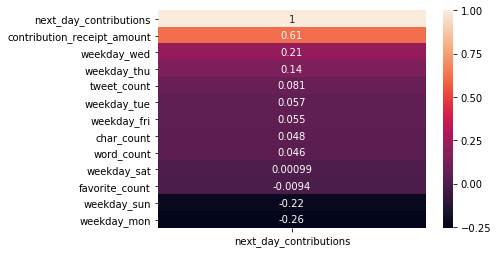

In [13]:
corr_heatmap(df,'next_day_contributions',False)


> There is very low correlation from character and word counts to campaign contributions. However, there does seem to be some signal coming from what day of the week Trump was tweeting. Specifically, Wednesday, Sundays, and Mondays have some correlation with contributions. Sundays and Mondays might have to do more with Trump not working during the weekend.

<a id='countvector'></a>
## Countvectorizer Analysis of Tweets 
  
> Using Countvectorizer, I look at what word counts and look to see if there is any correlation to campaign contributions. 

In [14]:
# Initialize the CountVectorizer
cvec = CountVectorizer(stop_words = 'english', max_df = .9, min_df = 3)
# Fit and transform the titles using the CountVectorizer
term_matrix = cvec.fit_transform(df['text'])

In [15]:
len(cvec.get_feature_names())

1802

> There are now 1802 words that countvectorizer has separated from the corpus. Below This information is turned into a dataframe and then analyzed.

In [16]:
# Convert the output of the CountVectorizer into a DataFrame
term_df = pd.DataFrame(term_matrix.toarray(),
                       columns = cvec.get_feature_names())

# Let's use dictionary comprehension to create a dictionary of summed words
term_dict = {word : term_df[word].sum() for word in term_df.columns}

# Create a dataframe with index = 'counts'
tcdf = pd.DataFrame(term_dict, index = ['counts'])

# Transpose the dataframe
tcdf = tcdf.T


>The dataframes cannot have timeseries indicies in order to do a correlation analysis.

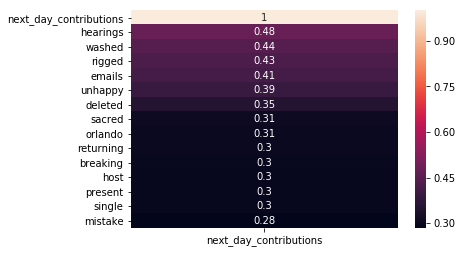

In [17]:
#Reset index and drop the date column.
contrib_df = contrib_df.reset_index().drop('Date', axis=1)
#Join the contribution dataframe to the countvector dataframe.
term_df= term_df.join(contrib_df)
#Drop first row.
term_df= term_df.drop([0])

corr_heatmap(term_df,'next_day_contributions',False)

> It looks like there is a decent amount of correlation from words such as rigged, emails, unhappy, scared, etc. Lots of the top words are in my opinion negative. It might suggest that these words along with a sentiment analysis could help predict next day contributions. 

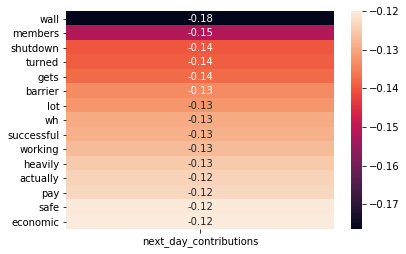

In [18]:
corr_heatmap(term_df,'next_day_contributions',True)

> It appears there are words that do lower Trump's contributions as well. The one that seems the most interesting is that the more he mentions the wall the lower his contributions are. It doesn't seem wise to keep using that term, "barrier" also seems to also have a negative correlation, which is a synonym for wall.

<a id='tfidf'></a>
## TF-IDF Analysis on Tweets . 
  
> Similar to the countvectorizer analysis, looking at the relationship of words/phrases frequencies from documents to the corpus might have a correlation to contributions. Below, I look at the single and two word ngrams of Trump's tweets.

In [19]:
#Fit and transform titles of AITA posts
tfidf = TfidfVectorizer(stop_words='english',ngram_range=(1,2))
tfidf.fit(df['text'])
term_mat = tfidf.transform(df['text'])

#Put into dataframe
term_tfidf = pd.DataFrame(term_mat.toarray(), columns=tfidf.get_feature_names())

In [20]:
#Organize the term_tfidf dataframe into the max, mean and sum of each of the words/phrases. Then look at the top 15.
col_max = {col: [term_tfidf[col].max(), 
                 term_tfidf[col].mean(),
                 term_tfidf[col].sum()] for col in term_tfidf.columns}

tf_df = pd.DataFrame(col_max, index = ['max','mean','sum']).T


tf_df.sort_values(by = 'max', ascending = False).head(15)

,max,mean,sum
nan,1.000000,0.005525,1.000000
dday75thanniversary,0.374746,0.002327,0.421171
mexico,0.340680,0.014553,2.634177
interior,0.335228,0.001852,0.335228
secretary interior,0.335228,0.001852,0.335228
china,0.317833,0.013504,2.444293
walls,0.286680,0.003417,0.618407
1994,0.283713,0.001567,0.283713
america great,0.278124,0.007354,1.331126
good morning,0.276659,0.001529,0.276659


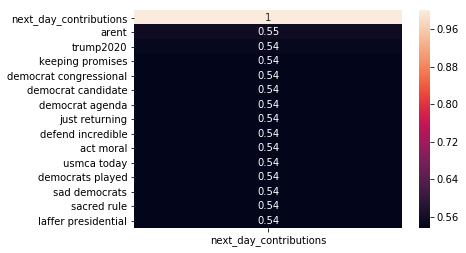

In [21]:
#Add contributions into the term_tfidf dataframe in order to run a correlation heatmap on the features.
term_tfidf= term_tfidf.join(contrib_df)
term_tfidf= term_tfidf.drop([0])
corr_heatmap(term_tfidf,'next_day_contributions',False)

> Given the phrases a ove, there seems to be a lot of signal going into the correlations to Trump's campaign contributions. These look like a good start to run through a model in order to predict contributions. One of the top phrases was trump2020 thus I am assuming there is a very strong correlation from him announcing his candidacy and his contributions.

<a id='outlier_tfidf'></a>
## TF-IDF on Outliers  
  
> This section is specifically looking at the top phrases in the contribution outliers and seeing if they are the same as the corpus correlations.

In [22]:
outlier_df= df.loc['2019-06-18':'2019-06-19'][['text','next_day_contributions']]

In [23]:
#Fit and transform outlier tweets.
tfidf_outliers = TfidfVectorizer(stop_words='english',ngram_range=(1,2))
tfidf_outliers.fit(outlier_df['text'])
term_mat_outliers = tfidf_outliers.transform(outlier_df['text'])

#Put into dataframe
term_tfidf_outliers = pd.DataFrame(term_mat_outliers.toarray(), columns=tfidf_outliers.get_feature_names())

In [24]:
col_max_outliers = {col: [term_tfidf_outliers[col].max(), 
                 term_tfidf_outliers[col].mean(),
                 term_tfidf_outliers[col].sum()] for col in term_tfidf_outliers.columns}

tf_df_out = pd.DataFrame(col_max_outliers, index = ['max','mean','sum']).T


tf_df_out.sort_values(by = 'max', ascending = False).head(15)

,max,mean,sum
amp,0.171123,0.085561,0.171123
trump2020,0.152194,0.090721,0.181443
country,0.128342,0.064171,0.128342
democrat,0.128342,0.064171,0.128342
want,0.128342,0.064171,0.128342
mueller,0.128342,0.064171,0.128342
best,0.128342,0.064171,0.128342
rigged,0.128342,0.064171,0.128342
mario,0.123325,0.061663,0.123325
job,0.123325,0.061663,0.123325


> Looking at the days where he recieved the most donations, Trump mostly tweeted about his campaign and the Mueller report. This is a little different than the corpus term frequencies, but not much. Thus it is hard to conclude whether or not these two days are skewing the data.

<a id='sentiment'></a>
## Sentiment Analysis  
  
> From looking at the words above that have the most correlation with next day campaign contributions a sentiment analysis might provide additional signal for a model to be fit. Below is that analysis:

In [25]:
#Instantiate SentimentIntesityAnalyzer
sia = SentimentIntensityAnalyzer()
dicts = []
for doc in df['text']:
    doc_dict = sia.polarity_scores(doc)
    sent = {
        'text': doc, 
        'neg':doc_dict['neg'],
        'neu':doc_dict['neu'],
        'pos':doc_dict['pos'],
        'compound':doc_dict['compound']
    }
    dicts.append(sent)
    
# Look at the top pos and neg tweets.
text_sent_df= pd.DataFrame(dicts)
text_sent_df.sort_values(by='pos',ascending=False).head(10)

,compound,neg,neu,pos,text
82,0.9153,0.131,0.417,0.452,good morning have a great day make america gre...
58,0.8591,0.000,0.655,0.345,thank you to our generous hosts in hanoi this ...
137,0.9886,0.042,0.614,0.344,our courageous and vigilant armed forces safeg...
145,0.9991,0.063,0.609,0.329,going to play golf right now with abeshinzo ja...
43,0.9947,0.027,0.647,0.326,i want to thank all republicans for the work y...
126,0.8593,0.074,0.623,0.302,democrats in congress must vote to close the t...
7,0.9958,0.066,0.635,0.299,endless wars especially those which are fought...
121,0.9965,0.028,0.684,0.288,i am continuing to monitor the situation in v...
3,0.9962,0.049,0.681,0.270,michael pillsbury interviewed by cvpayne they ...
128,0.9853,0.097,0.639,0.264,beautiful evening in panama city beach florida...


In [26]:
text_sent_df.sort_values(by='neg',ascending=False).head(10)

,compound,neg,neu,pos,text
16,-0.6152,0.240,0.621,0.139,the left has become totally unhinged they no l...
44,-0.9883,0.238,0.680,0.082,california has been forced to cancel the mas...
93,-0.9800,0.227,0.619,0.154,the republican party is the party of the ameri...
105,-0.8452,0.211,0.664,0.125,a must read andy mccarthys column today dirty ...
22,-0.9846,0.208,0.679,0.113,congratulations to mariano rivera on unanimous...
86,-0.9886,0.198,0.682,0.121,will be heading to grand rapids michigan toni...
65,-0.9636,0.194,0.721,0.085,wall street journal more migrant families cros...
101,-0.9807,0.193,0.712,0.095,great heroes jobless claims at 50 year low i ...
117,-0.9489,0.189,0.677,0.134,beautiful trumprally tonight in green bay wisc...
149,-0.9967,0.186,0.708,0.106,how do you impeach a republican president for ...


In [27]:
text_sent_df.describe()

,compound,neg,neu,pos
count,181.000000,181.000000,181.000000,181.000000
mean,0.386555,0.111779,0.717983,0.159193
std,0.796151,0.047657,0.095980,0.062798
min,-0.996700,0.000000,0.000000,0.000000
25%,-0.469200,0.078000,0.690000,0.124000
50%,0.911600,0.112000,0.722000,0.156000
75%,0.985300,0.140000,0.758000,0.189000
max,0.999600,0.240000,1.000000,0.452000


> Overall Trump's tweets tend to be neutral in sentiment. At least this is based on words used. Given his tone, the model might not be picking up on sarcasm. 

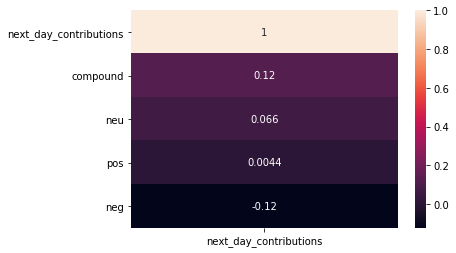

In [28]:
#Join the Contributions to the sentiment dataframe to look at correlations to contributions.
text_sent_df= text_sent_df.join(contrib_df).drop([0])
corr_heatmap(text_sent_df,'next_day_contributions',False)

> Strangely, there doesn't look like much signal coming from the sentiment, contrary to the tf-idf analysis. There will not be enough signal here to run a model using the sentiment.

<a id='svd'></a>
## Singular Value Decomposition(SVD) Analysis

### LSA on TF-IDF Data  
  
> In this section LSA unsupervised learning is used to try determine the best way to combine features to explain variance in the data.

In [29]:
#Instantiate and fit an SVD on the Tf-Idf dataframe.
SVD_tfidf= TruncatedSVD(n_components=175)
svd_tfidf = SVD_tfidf.fit_transform(term_tfidf.drop(columns= 'next_day_contributions'))
svd_tfidf.shape

(180, 175)

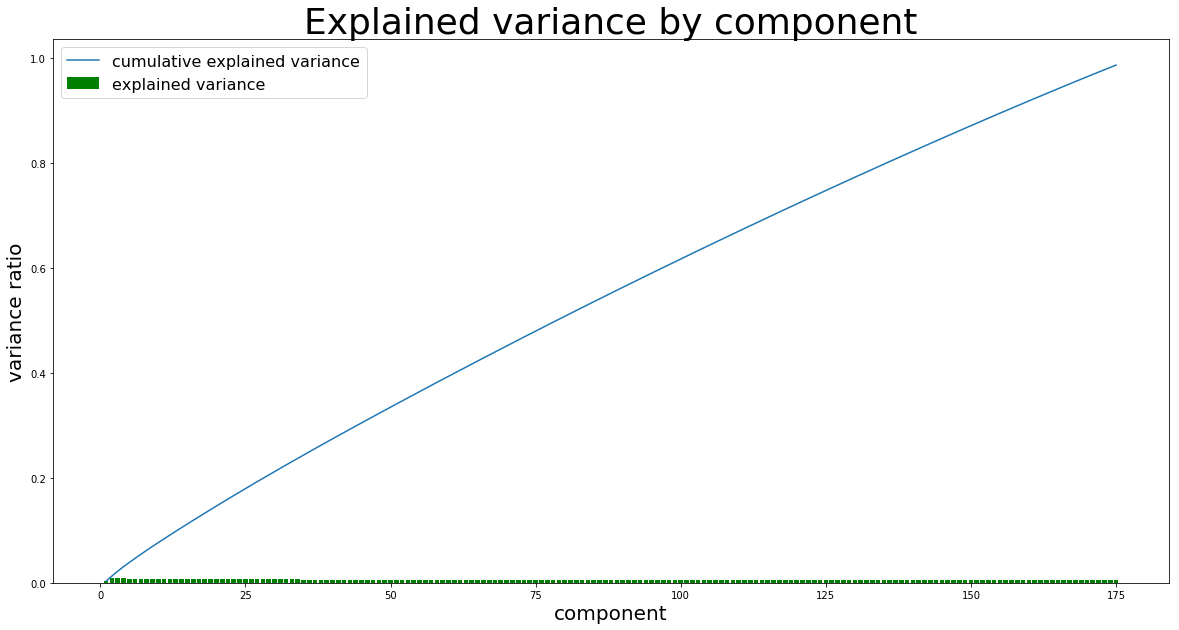

In [30]:
plot_exp_var(SVD_tfidf,175)

> Even transformed into components that explain the most variance, there is not much signal to be had from the Tf-Idf information. 

In [31]:
#Create a dataframe to look at the weights of each feeature is going into each component.
component_names = ["component_"+str(i+1) for i in range(175)]
svd_df = pd.DataFrame(svd_tfidf,
                      columns=component_names)

#Transpose dataframe for readability
loadings_tifdf = pd.DataFrame(SVD_tfidf.components_,
                        index=component_names,
                        columns=term_tfidf.drop(columns= 'next_day_contributions').columns).T

loadings_tifdf['abs_component_1'] = np.abs(loadings_tifdf.component_1)
loadings_tifdf['abs_component_2'] = np.abs(loadings_tifdf.component_2)
loadings_tifdf['abs_component_3'] = np.abs(loadings_tifdf.component_3)

In [32]:
# Top 10 words that contributes to component 1
loadings_tifdf.sort_values('abs_component_1',ascending=False).head(10)[['component_1']]


,component_1
great,0.177754
amp,0.171677
border,0.140063
people,0.124025
democrats,0.123170
president,0.112561
country,0.099679
news,0.095969
fake,0.095857
just,0.093917


In [33]:
# Top 10 words that contributes to component 2
loadings_tifdf.sort_values('abs_component_2',ascending=False).head(10)[['component_2']]

,component_2
wall,0.227916
border,0.199741
security,0.130874
mueller,-0.126590
border security,0.125988
collusion,-0.119233
obstruction,-0.099583
southern border,0.091193
southern,0.089727
built,0.084455


In [34]:
# Top 10 words that contributes to component 3
loadings_tifdf.sort_values('abs_component_3',ascending=False).head(10)[['component_3']]

,component_3
china,0.332815
tariffs,0.128599
border,-0.117477
billion,0.111699
billion dollars,0.105849
dollars,0.094483
farmers,0.084710
democrats,-0.084574
buy,0.084445
deal,0.076494


> Above are the top 10 words that go into the first three components that explain the most variance in the data.

### LSA on CVEC  
> Similar to the tf-idf LSA analysis above, the countvectorized tweets appeared to have correlations to the campaign contributions. If this is the case maybe combining them into components could help build a better predictor of what words are best used to raise funds.

In [35]:
SVD = TruncatedSVD(n_components=150)
svd_matrix = SVD.fit_transform(term_df.drop(columns= 'next_day_contributions'))
svd_matrix.shape

(180, 150)

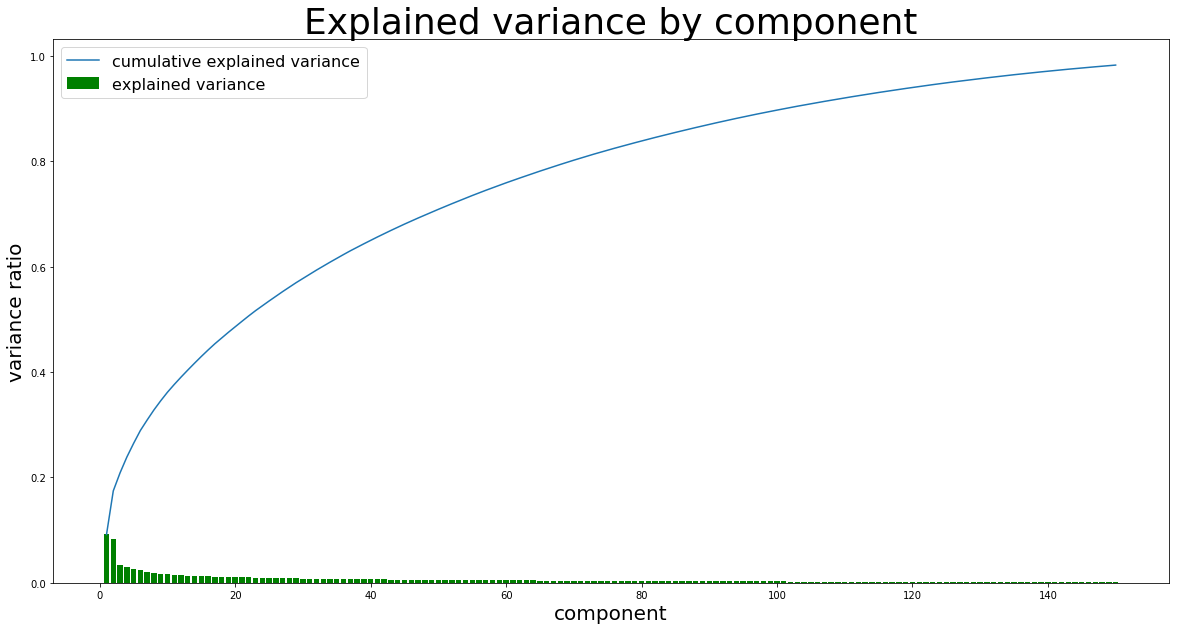

In [36]:
plot_exp_var(SVD,150)

> There appears to be more signal to be gained from the LSA on the countvectorized tweets than the tf-idf tweets data. Especially from the first two components, but even the top 20 look to have some information.

In [37]:
# How many components do we need to represent at leat %95 of the variance in the data?
np.where(np.cumsum(SVD.explained_variance_ratio_) < .95)[0][-1]+1

125

In [38]:
component_names = ["component_"+str(i+1) for i in range(150)]
#Create a dataframe to look at the weights of each feeature is going into each component.
svd_df = pd.DataFrame(svd_matrix,
                      columns=component_names)

loadings = pd.DataFrame(SVD.components_,
                        index=component_names,
                        columns=term_df.drop(columns= 'next_day_contributions').columns).T

loadings['abs_component_1'] = np.abs(loadings.component_1)
loadings['abs_component_2'] = np.abs(loadings.component_2)
loadings['abs_component_3'] = np.abs(loadings.component_3)

In [39]:
# Top 10 words that contributes to component 1
loadings.sort_values('abs_component_1',ascending=False).head(10)[['component_1']]


,component_1
great,0.349794
amp,0.336806
china,0.192415
people,0.189924
president,0.180302
democrats,0.178627
border,0.174216
just,0.149025
country,0.147425
news,0.121242


In [40]:
# Top 10 words that contributes to component 2
loadings.sort_values('abs_component_2',ascending=False).head(10)[['component_2']]


,component_2
china,0.562738
tariffs,0.270058
billion,0.266345
dollars,0.257473
products,0.195266
farmers,0.174437
border,-0.164987
democrats,-0.134907
people,-0.134774
deal,0.120235


In [41]:
# Top 10 words that contributes to component 3
loadings.sort_values('abs_component_3',ascending=False).head(10)[['component_3']]

,component_3
border,-0.371684
mexico,-0.253509
president,0.249061
amp,-0.225001
china,0.220546
wall,-0.206500
great,0.191932
trump,0.182112
dollars,-0.158499
billion,-0.141205


> Talking about China and the democrats definitely seem to have signal across all components. Regardless it is interesting to see what each component is made of. There looks like there may be enough signal in this data to run a model on. 

<a id='csv'></a>
## Export CSV files of datasets to run predictive models on

In [42]:
#Export the feature engineered dataset.
df.to_csv('../datasets/frequency_dataset.csv',index_label=False)

In [43]:
#Export the countvector LSA component dataset.
#Merge the svd dataframe with the contributions associated with each feature.
new_df= svd_df.merge(contrib_df,right_index=True,left_index=True)
new_df.to_csv('../datasets/lsa_dataset.csv',index_label=False)

<a id='conclusions'></a>
## Conclusions  
  
Based upon the exploratory data analysis there seemed to be some correlations between Trump's tweets and his campaign contributions. There were a few surprises, based upon visual interpretation of the bag-of-words analysis it seemed as though there might be signal in Trump's sentiment. However, after a sentiment analysis there didn't seem to be any correlation to his ability to raise money.  

The features that will be used to run predictive models on will be the frequency and times of his tweets from feature engineering and the countvectorized tweets. The reasoning for these choices is that the tweet number of likes and times have correlations that match intuition. If people are driven to like his tweets by his frequncy and timing of his post, they should be more motivated to contribute to his campaign.  

For the countvectorized tweets, I will be using the LSA components. The rationale behind this is that it contains all most of the information held in the full countvecotiaed tweet with less features. This will hopefully combat over-fitting in the model.  

Continue to next notebook for the modeling process.